In [1]:
import numpy as np
import cv2
from math import floor

import os, random
from keras.preprocessing import image
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [148]:
def inv_perspective(image, camera_param):
    """ Inverse perspective Mapping """
    roi_left = -10
    roi_right = 10
    roi_near = get_interpolation(camera_param, image.shape[1])
    print('Blind area ', roi_near)
    length = 100

    objpoint = np.array([(roi_left, 0, roi_near),
                         (roi_right, 0, roi_near),
                         (roi_left, 0, roi_near + length),
                         (roi_right, 0, roi_near + length)], dtype='double')

    imgpoint, _ = cv2.projectPoints(objpoint, camera_param[2], camera_param[3],
                                    camera_param[0], camera_param[1])

    pts1 = np.float32([
        [imgpoint[0][0][0], imgpoint[0][0][1]],
        [imgpoint[1][0][0], imgpoint[1][0][1]],
        [imgpoint[2][0][0], imgpoint[2][0][1]],
        [imgpoint[3][0][0], imgpoint[3][0][1]]])

    scale = 20    
    out_width = 2 * (scale * roi_right)
    out_height = scale * length
    
    pts2 = np.float32([
            [0, out_height],
            [out_width, out_height],
            [0, 0],
            [out_width, 0]])
    
    M = cv2.getPerspectiveTransform(pts1, pts2)
    
    #конец кода Кати
    
    #код Светы

    cols, rows, chan = image.shape
    inputCorners = np.array([[0, 0], [rows, 0], [0, cols], [rows, cols]], dtype='float32')
    inputCorners = np.array([inputCorners])

    #Положение углов изображения после трансформации
    outputCorners = cv2.perspectiveTransform(inputCorners, M)

    #Строим ограничительную рамку
    x,y,w,h = cv2.boundingRect(outputCorners)
    #x1,y1,w1,h1 = cv2.boundingRect(inputCorners)

    #Сдвигаем опорные точки (результирующие)
    pts2 = np.float32([
            [0, h],
            [w, h],
            [0, 0],
            [w, 0]])

    return [w, h, cv2.getPerspectiveTransform(pts1, pts2)]
    #w and h for warptransform


def get_interpolation(camera_param, find_pix):
    """ Find the nearest point to train on the image """
    test_obj = []
    max_meter = 20
    min_meter = 3
    for i in range(min_meter, max_meter):
        test_obj.append((0, 0, i))

    test_point = np.array(test_obj, dtype='double')
    test_img, _ = cv2.projectPoints(test_point, camera_param[2], camera_param[3],
                                    camera_param[0], camera_param[1])
    p = []
    for t in test_img:
        if t[0][1] > 0:
            p.append(t[0][1])

    l = len(p) - 1
    lp = len(p)
    low = max_meter - lp
    m = 16
    met = 0

    while l > 0:
        if find_pix > floor(p[l]):
            l -= 1
        else:
            diff = floor(p[l]) - floor(p[l + 1])
            f = floor(p[l]) - find_pix
            met = f / diff
            ind = l
            m = ind + low
            break

    result = float('{0:.1f}'.format(m + met))

    return result

roi_left = -10
roi_right = 10
length = 100
scale = 20    
out_width = 2 * (scale * roi_right)
out_height = scale * length
    
""" Convert pixel points from original image to local coordinates (meters) """
# points - array of points on the original image
def toreal_coord(converted_pts, examp_image, camera_param, w, h):
    roi_near = get_interpolation(camera_param, examp_image.shape[1])
    
    m_coord = []
    for pt in converted_pts:
        x, y = pt[0][0], pt[0][1]
        x, y = int(x), int(y)
    
        #x = (x / out_width * (roi_right-roi_left) + roi_left)*-1
        #y = (out_height - y) / out_height * length + roi_near
        
        x = (x / w * (roi_right-roi_left) + roi_left) #-1 only for negative on right side 
        y = (h - y) / h * length + roi_near
    
        m_coord.append((x, y))

    return m_coord

In [82]:
#load image

path = r'C:\Users\RZD.GENERATION\Downloads\data\all' 
pathX = path + r'\train'
pathY = path + r'\trainmask'

#path = '/content/all'
#pathX = path + '/train'
#pathY = path + '/trainmask'
 
data_names = os.listdir(pathX)
dataX = []
dataY = []

#для кода Кати обязательно
h = 2064
w = 1544

for count, smpl in enumerate(data_names):
    img = image.img_to_array(image.load_img(pathX+"/"+smpl).resize((h,w)))
    mask = image.img_to_array(image.load_img(pathY+"/"+smpl).resize((h,w)))
    dataX.append(img/255.)
    dataY.append(mask/255.)
    if count == 20:
        break

In [76]:
mtxL = [3.100083007812500000e+03,0.000000000000000000e+00,1.024000000000000000e+03,0.000000000000000000e+00,3.100083007812500000e+03,7.680000000000000000e+02, 0.000000000000000000e+00,0.000000000000000000e+00,1.000000000000000000e+00]
mtxR = [3.100884521484375000e+03,0.000000000000000000e+00,1.024000000000000000e+03,0.000000000000000000e+00,3.100884521484375000e+03,7.680000000000000000e+02,0.000000000000000000e+00,0.000000000000000000e+00,1.000000000000000000e+00]
distL = [0., 0., 0., 0., 0.]
distR = [0., 0., 0., 0., 0.]
rvec = [0.156107,  0.035085,  0.006041]
tvec = [-0.016078,  4.922029, -1.911572]

camera_param = [np.array(mtxL).reshape((3,3)), np.array(distL), np.array(rvec), np.array(tvec)]

Blind area  10.1
Transformation matrix 
 [[-5.66425032e-01 -1.22884507e+00  9.87339378e+02]
 [ 2.39195710e-02 -4.96915744e+00  2.03193737e+03]
 [ 1.20205483e-05 -3.61734687e-03  1.00000000e+00]]
Spec point(s) bird view coordinates  [[[ 347.06467 1168.0726 ]]]
Spec point(s) real coordinates  [(0.16105417276720324, 18.131496062992127)]


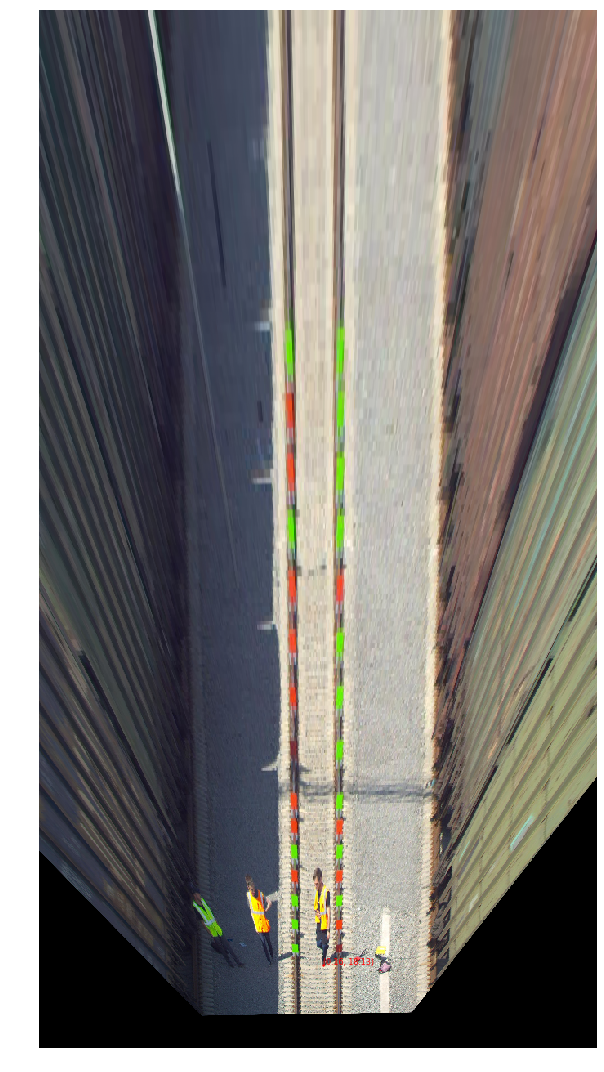

In [91]:
#import itertools

examp_image = dataX[0]

#transform matrix calculation
w, h, M = inv_perspective(examp_image, camera_param)
print('Transformation matrix \n', M)

#taking spec points to reverse
#points = [[list(i)] for i in itertools.product(range(examp_image.shape[0]), range(examp_image.shape[1]))] 
#print(points)
#points = [[[497, 559]]]
points = [[[1177, 1177]]]
pts = np.float32(points)

#converting points to birdview and getting real coordinates
converted_pts = cv2.perspectiveTransform(pts, M)
#converted_pts = random.sample(converted_pts.tolist(), 10)
print('Spec point(s) bird view coordinates ', converted_pts)
m_coord = toreal_coord(converted_pts, examp_image, camera_param, w, h)
print('Spec point(s) real coordinates ', m_coord)

bv = cv2.warpPerspective(examp_image, M, ((w, h)))
#bv = cv2.pyrDown(bv) 

plt.figure(figsize = (10, 30))
plt.imshow(bv)
plt.axis('off')

for i in range(len(converted_pts)):
    x = np.round(m_coord[i][0], 2)
    y = np.round(m_coord[i][1], 2)
    plt.scatter(converted_pts[i][0][0], converted_pts[i][0][1], s=2, c='red', marker='o')
    plt.annotate((x,y), (converted_pts[i][0][0], converted_pts[i][0][1]), color='red', fontsize=8)
plt.show()

Blind area  10.1
[0. 1.]


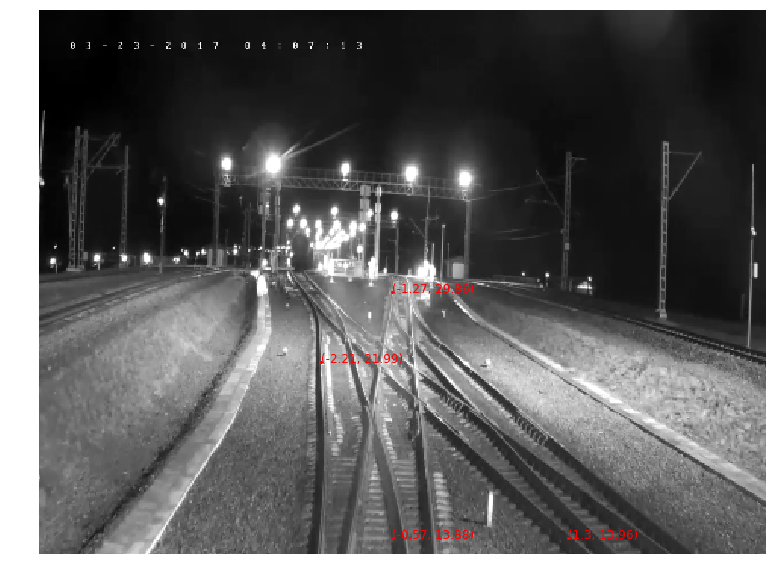

Need to take radius (in pixels) = 28.223684210526315
0.038974358974358976
Object (-2.2108345534407023, 21.989763779527557) on rails detected: 39.82407037185126 %
Katya's method (-2.2108345534407023, 21.989763779527557)
My method (-2.9425641025641025, 5.885128205128205)
----------------
Object (1.303074670571009, 13.958267716535433) on rails detected: 0.0 %
Katya's method (1.303074670571009, 13.958267716535433)
My method (1.7343589743589745, 1.90974358974359)
----------------
Object (-1.2737920937042464, 29.863779527559053) on rails detected: 27.389044382247103 %
Katya's method (-1.2737920937042464, 29.863779527559053)
My method (-1.6953846153846155, 9.782564102564104)
----------------
Object (-0.5710102489019029, 13.879527559055118) on rails detected: 68.26923076923077 %
Katya's method (-0.5710102489019029, 13.879527559055118)
My method (-0.76, 1.870769230769231)
----------------


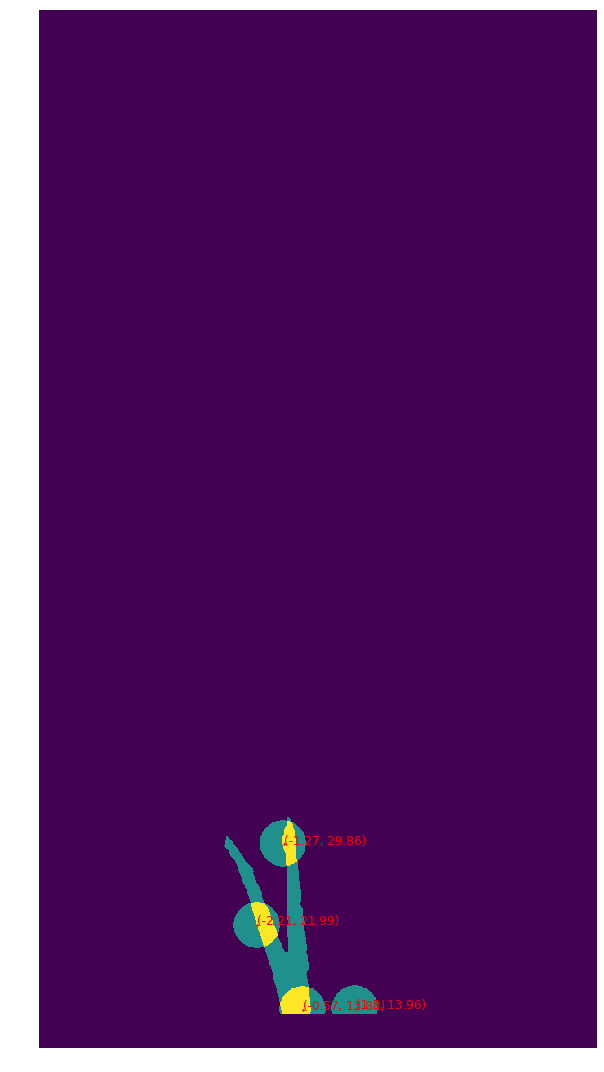

In [232]:
#object vs rails detection

ind_image = 12
examp_image = dataY[ind_image]

w, h, M = inv_perspective(examp_image, camera_param)
bv = cv2.warpPerspective(examp_image, M, ((w, h)))

#here preproc with bird view mask
#bv = cv2.GaussianBlur(bv, (5,5), 0)
#bv = cv2.boxFilter(bv, bv, 5,5)
#bv[bv>0.01] = 1.
#bv = cv2.Canny(bv, 0.2, 1, L2gradient=False)
bv = cv2.medianBlur(bv, 5)
thr = 0.1
bv[bv>thr] = 1.
bv[bv<=thr] = 0.
print(np.unique(bv))

point = [[[800, 1000]], [[1500, 1500]], [[1000, 800]], [[1000, 1500]]]
pt = np.float32(point)
converted_pts = cv2.perspectiveTransform(pt, M)
m_coord = toreal_coord(converted_pts, examp_image, camera_param, w, h)

plt.figure(figsize = (30, 10))
plt.imshow(dataX[ind_image])
plt.axis('off')
for i in range(len(converted_pts)):
    x = np.round(m_coord[i][0], 2)
    y = np.round(m_coord[i][1], 2)
    plt.scatter(pt[i][0][0], pt[i][0][1], s=4, c='red', marker='o')
    plt.annotate((x,y), (pt[i][0][0], pt[i][0][1]), color='red', fontsize=12)
plt.show()

bv = cv2.cvtColor(bv, cv2.COLOR_BGR2GRAY)
x = np.arange(0, w)
y = np.arange(0, h)
list_arr = []

#let's take end of road into account (super raw)
vs = np.sum(bv, axis=1)
ind_vs = np.where(vs>0.)[0]
top = ind_vs[0] #+step
bottom = ind_vs[-1] #+step

#count distance with mask
real_track = 1520 #in mm

#let's take 20 iterations
step = 3 #pix
it = 20
pix_track = []
for i in range(1, it):
    ind = np.where(bv[bottom - step*i,:]>0)[0]
    left_rail, right_rail = ind[0], ind[-1]
    pix_track.append(np.float32(right_rail - left_rail))
pix_track = np.median(pix_track) #median or mean??

#geting proportion
prop = pix_track/real_track #pix in mm
r = prop*1100 #let's take 110sm 
print('Need to take radius (in pixels) =', r)
prop = 0.001/prop
print(prop)

for c, obj in enumerate(converted_pts):
    arr = np.zeros((h, w))

    #coordinates for object centr
    cx = int(obj[0][0])
    cy = int(obj[0][1])

    mask = (x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 <= r**2
    mask[:top, :] = 0
    mask[bottom:, :] = 0

    arr[mask] = 1.
    list_arr.append(arr)
    
    div = np.sum(arr)
    if div:
        coinsid = np.sum(arr*bv)/np.sum(arr) * 100
    else:
        coinsid = 0.
    print('Object', m_coord[c], 'on rails detected:', coinsid, '%')
    
    #to real coordinates
    real_coord = ((cx-w/2)*prop, (h-cy)*prop)
    
    print("Katya's method",  m_coord[c])
    #blind area isn't taken into account
    print('My method', real_coord)
    print('----------------')
    

arr = sum(list_arr)
plt.figure(figsize = (10, 30))
plt.imshow(arr+bv)
plt.axis('off')

for i in range(len(converted_pts)):
    x = np.round(m_coord[i][0], 2)
    y = np.round(m_coord[i][1], 2)
    plt.scatter(converted_pts[i][0][0], converted_pts[i][0][1], s=2, c='red', marker='o')
    plt.annotate((x,y), (converted_pts[i][0][0], converted_pts[i][0][1]), color='red', fontsize=12)
plt.show()

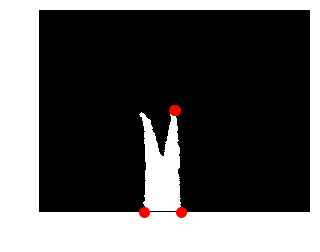

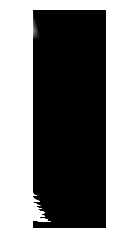

In [60]:
#bird view based on segmentartion WRONG!

exmp_mask = dataY[12]

plt.imshow(exmp_mask) 
plt.axis('off')

border = 0

step = 5
vs = np.sum(exmp_mask, axis=1)
btop = np.where(vs>0.)[0]
top, bottom = btop[0]+step, btop[-1]-step

hbottom = np.where(exmp_mask[bottom,:]>0.)[0]
left_bottom, right_bottom = hbottom[0], hbottom[-1]
htop = np.where(exmp_mask[top,:]>0.)[0]
left_top, right_top = htop[0], htop[-1]

plt.scatter(right_top+border, top, s=100, c='red', marker='o')
plt.scatter(right_bottom+border, exmp_mask.shape[0], s=100, c='red', marker='o')
plt.scatter(left_top-border, top, s=100, c='red', marker='o')
plt.scatter(left_bottom-border, exmp_mask.shape[0], s=100, c='red', marker='o')
plt.show()

pts1 = np.float32([
        [left_top-border, top],
        [right_top+border, top],
        [left_bottom-border, exmp_mask.shape[0]],
        [right_bottom+border, exmp_mask.shape[0]]])
   
out_width = 100
out_height = 300

pts2 = np.float32([
        [0, 0],       
        [out_width, 0],
        [0, out_height], 
        [out_width, out_height]])

M = cv2.getPerspectiveTransform(pts1, pts2)

converted_pts = cv2.warpPerspective(exmp_mask, M, ((out_width, out_height)))

#plt.figure(figsize = (20, 30))
plt.imshow(1-converted_pts)
plt.axis('off')
plt.show()

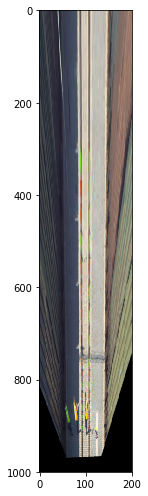

In [8]:
#show with cv2

%matplotlib inline
from skimage.io import imshow
plt.figure(figsize=(5, 7))
cv2.circle(bv, (converted_pts[0][0][0], converted_pts[0][0][1]), 5, (250,0,0), -1)
imshow(bv)